<a href="https://colab.research.google.com/github/bylehn/auxetic_networks_jaxmd/blob/abhishek/test-auxetic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext jupyter_ai_magics
%env AI21_API_KEY=oMh4aSAWigjQJ555s5I4JfPYqkIW4hqw

In [1]:
import jax.numpy as np
from jax import random
from jax import ops
from jax.config import config; config.update("jax_enable_x64", True)
from jax_md import space, energy, minimize, simulate, quantity
from jax import random, grad, vmap
from jax import jit
from jax import lax
import networkx as nx
import numpy as onp
from scipy.spatial import Delaunay
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import seaborn as sns
  
sns.set_style(style='white')

def format_plot(x, y):  
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
def plot_configuration(node_positions, bond_array, box_size):
    # Create an empty plot
    fig, ax = plt.subplots()

    # Plot the node positions
    for i, position in enumerate(node_positions):
        ax.scatter(position[0], position[1], s=50, c='red', label='Node')

    # Plot the bonds
    for bond in bond_array:
        start_node = node_positions[bond[0]]
        end_node = node_positions[bond[1]]
        ax.plot([start_node[0], end_node[0]], [start_node[1], end_node[1]], 'b-', linewidth=2, label='Bond')


    # Customize the plot
    ax.set_xlim(0, box_size)
    ax.set_ylim(0, box_size)

    # Show the plot
    plt.show()

In [3]:
def createDelaunayGraph(NS, rseed, r_c, del_x):

    # This function creates a Delaunay graph of a set of points.

    # Parameters:
    #   NS: The number of points to generate.
    #   rseed: The random seed to use.
    #   r_c: The radius of the circumcircle of each edge in the graph.
    #   del_x: max noise magnitude from square lattice

    # Returns:
    #   N: The number of points in the graph.
    #   G: The graph object.
    #   X: The coordinates of the points.
    #   E: The edges of the graph.

    # Set the random seed.
    onp.random.seed(rseed)

    # Generate the points.
    xm, ym = onp.meshgrid(onp.arange(1, NS + 1), onp.arange(1, NS + 1))
    X = onp.vstack((xm.flatten(), ym.flatten())).T
    N = X.shape[0]

    # Add some noise to the points.
    X = X + del_x * 2 * (0.5 - onp.random.rand(N, 2))

    # Create the Delaunay triangulation.
    DT = Delaunay(X)

    # Get the edges of the triangulation.
    ET = onp.empty((0, 2), dtype=int)
    for T in DT.simplices:
        ET = onp.vstack((ET, [T[0], T[1]], [T[1], T[2]], [T[0], T[2]]))

    # Sort the edges.
    ET = onp.sort(ET)

    # Get the radii of the circumcircles of the edges.
    R = onp.linalg.norm(X[ET[:, 0], :] - X[ET[:, 1], :], axis=1)

    # Keep only the edges with radii less than r_c.
    EN = ET[R < r_c, :]

    # Create the adjacency matrix.
    A = onp.zeros((N, N))
    A[EN[:, 0], EN[:, 1]] = 1

    # Get the lengths of the edges.
    L = onp.linalg.norm(X[ET[:, 0], :] - X[ET[:, 1], :], axis=1)

    # Keep only the edges with lengths less than r_c.
    EL = L[R < r_c]

    # Create the graph object.
    G = nx.Graph(A)

    # Get the edges of the graph.
    E = onp.array(G.edges)

    # Get the lengths of the edges.
    L = onp.linalg.norm(X[E[:, 0], :] - X[E[:, 1], :], axis=1)

    return N, G, X, E, L

def getSurfaceNodes(G, NS):
    # Retrieve the list of nodes in the graph G
    nodes = np.array(list(G.nodes))
    # Calculate the x and y coordinates of the nodes based on the grid size NS
    x_values = nodes % NS
    y_values = nodes // NS
    # Find the nodes located on the top surface (y = NS - 1)
    top_nodes = nodes[y_values == NS - 1]
    # Find the nodes located on the bottom surface (y = 0)
    bottom_nodes = nodes[y_values == 0]
    # Find the nodes located on the left surface (x = 0)
    left_nodes = nodes[x_values == 0]
    # Find the nodes located on the right surface (x = NS - 1)
    right_nodes = nodes[x_values == NS - 1]
    # Return a dictionary with surface names as keys and node arrays as values
    return {
        'top': top_nodes,
        'bottom': bottom_nodes,
        'left': left_nodes,
        'right': right_nodes
    }

### Functions

In [23]:
def make_box(R, padding):
    """
    Defines a box length

    R: position matrix
    padding: amount of space to add to the box
    """
    box_length = (np.max((np.max(R[:,0], R[:,1])) - np.min(((np.min(R[:,0], R[:,1])))))) + padding
    return box_length
    
def create_spring_constants(R,E,k_1):
    """
    Creates spring constants for each edge in the graph

    k_1: spring constant for a spring of unit length
    R: position matrix
    E: edge matrix
    """
    displacements = R[E[:, 0],:] - R[E[:, 1], :]
    distance = np.linalg.norm(displacements, axis=1)
    return (k_1/distance).reshape(-1,1),distance

@jit
def compute_distance(point1, point2):
    """
    Calculate the Euclidean distance between two points.
    """
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

@jit
def displace_sources(R, source_idx, delta):
    """
    Adjust the position of two source nodes along their connecting vector.

    R: position matrix
    source_idx: indices of the source nodes
    delta: amount to displace the source nodes
    """
    source_vector = R[source_idx[1], :] - R[source_idx[0], :]
    unit_vector = source_vector / np.linalg.norm(source_vector)
    
    # Displace both source points along the unit vector, half the delta in opposite directions.
    displacement = 0.5 * delta * unit_vector
    R = R.at[source_idx[0], :].set(R[source_idx[0]] + displacement)
    R = R.at[source_idx[1], :].set(R[source_idx[1]] - displacement)
    return R


#@jit
def constrained_force_fn(R, energy_fn, source_idx):
    """
    Calculates forces with frozen sources.

    R: position matrix
    energy_fn: energy function
    source_idx: indices of the source nodes
    """
    force_fn = quantity.force(energy_fn)

    def new_force_fn(R):
        total_force = force_fn(R)
        total_force = total_force.at[source_idx, :].set(0.0)
        return total_force

    return new_force_fn


@jit
def obtain_strain(initial_R, final_R, source_idx, target_idx):
    """
    Calculate the strains for the source and target regions based on initial and final R.

    initial_R: initial position matrix
    final_R: final position matrix
    source_idx: indices of the source nodes
    target_idx: indices of the target nodes
    """
    # Extract R for source and target regions.
    initial_source_R = initial_R[source_idx, :]
    final_source_R = final_R[source_idx, :]
    initial_target_R = initial_R[target_idx, :]
    final_target_R = final_R[target_idx, :]

    # Calculate distances for initial and final configurations.
    d_source_initial = compute_distance(initial_source_R[0], initial_source_R[1])
    d_source_final = compute_distance(final_source_R[0], final_source_R[1])
    d_target_initial = compute_distance(initial_target_R[0], initial_target_R[1])
    d_target_final = compute_distance(final_target_R[0], final_target_R[1])

    # Calculate the strains.
    source_strain = (d_source_final - d_source_initial) / d_source_initial
    target_strain = (d_target_final - d_target_initial) / d_target_initial

    return source_strain, target_strain

@jit
def fitness(source_strain, target_strain, goal_strain):
    """
    Calculate the fitness based on the strains.

    source_strain: strain of the source nodes
    target_strain: strain of the target nodes
    goal_strain: strain that we want to achieve at the target nodes
    """
    eta = target_strain / source_strain
    return np.abs(1 - eta / goal_strain)

@jit
def update_kbonds(gradients, k_bond, learning_rate = 0.01):
    """
    Updates spring constants based on gradients.

    
    """
    gradients_perpendicular = gradients - np.mean(gradients)
    gradients_normalized = gradients_perpendicular / np.max(gradients_perpendicular)
    k_bond_new = k_bond * (1 - learning_rate * gradients_normalized)

    return k_bond_new

@jit
def compute_force_norm(fire_state):
    return np.linalg.norm(fire_state.force)


def remove_zero_rows(log_dict):
    """
    Remove rows (entries) in the log dictionary that are all zeros.
    """
    for key in log_dict:
        log_dict[key] = log_dict[key][~np.all(log_dict[key] == 0.0, axis=(1, 2))]
    return log_dict

### Consolidated Function

In [29]:
max_steps = 1000
first_min_steps = 200
write_every = 10
tolerance = 1e-6  # Set the desired tolerance for the minimization.


def simulate_allostery(R, k_bond, source_idx, target_idx, shift, eta_star, ds, displacement, E, bond_lengths):
    """
    Simulates the allosteric process.

    """
    log_first_min = {
    #'energy': np.zeros((steps,)),
    'force': np.zeros((max_steps // write_every,) + R.shape),
    'position': np.zeros((max_steps // write_every,) + R.shape) 
    }
    log_second_min = {
    #'energy': np.zeros((steps,)),
    'force': np.zeros((max_steps // write_every,) + R.shape),
    'position': np.zeros((max_steps // write_every,) + R.shape)
    }

    def step_fn(i, state_and_log):
        """
        Minimizes the configuration at each step, after pinching the source nodes.

        i: step number
        state_and_log: state and log dictionary
        """
        fire_state, log = state_and_log
        
        #energy = quantity.energy(energy_fn)
        #log['energy'] = log['energy'].at[i].set(energy(fire_state.position))
        #log['energy'] = lax.cond(i % write_every == 0,
        #                         lambda e: e.at[i // write_every].set(np.array(energy_fn(fire_state.position))),
        #                         lambda e: e,
        #                         log['energy'])

        log['force'] = lax.cond(i % write_every == 0,
                                lambda p: p.at[i // write_every].set(fire_state.force),
                                lambda p: p,
                                log['force'])

        log['position'] = lax.cond(i % write_every == 0,
                                lambda p: p.at[i // write_every].set(fire_state.position),
                                lambda p: p,
                                log['position'])
        
        
        fire_state = fire_apply(fire_state)
        return fire_state, log

    # First minimization before pinching the source nodes.
    energy_fn = energy.simple_spring_bond(displacement, E, length=bond_lengths, epsilon=k_bond[:, 0])  

    fire_init, fire_apply = minimize.fire_descent(energy_fn, shift)
    fire_apply = jit(fire_apply)
    #step = jit(lambda i, state: fire_apply(state))
    fire_state = fire_init(R)
    fire_state, log_first_min = lax.fori_loop(0, first_min_steps, step_fn, (fire_state, log_first_min))
    #fire_state = lax.fori_loop(0, steps, step, fire_state)
    R_init = fire_state.position

    # Displace the source nodes.
    R_new = displace_sources(R_init, source_idx, ds)

    # Second minimization after pinching the source nodes.
    energy_fn = energy.simple_spring_bond(displacement, E, length=bond_lengths, epsilon=k_bond[:, 0])
    force_fn = constrained_force_fn(R_new, energy_fn, source_idx)
    fire_init, fire_apply = minimize.fire_descent(force_fn, shift)
    fire_state = fire_init(R_new)
    previous_force_norm = compute_force_norm(fire_state)
    current_force_norm = np.inf  # Initializing to a high value
    #fire_state = lax.fori_loop(0, steps, step, fire_state)
    #fire_state, log_second_min = lax.fori_loop(0, steps, step_fn, (fire_state, log_second_min))
    state_and_log = (fire_state, log_second_min)
    step = 0
    while abs(previous_force_norm - current_force_norm) > tolerance:
        step += 1
        fire_state, log = state_and_log
        
        #energy = quantity.energy(energy_fn)
        #log['energy'] = log['energy'].at[i].set(energy(fire_state.position))
        #log['energy'] = lax.cond(i % write_every == 0,
        #                         lambda e: e.at[i // write_every].set(np.array(energy_fn(fire_state.position))),
        #                         lambda e: e,
        #                         log['energy'])
        log['force'] = lax.cond(step % write_every == 0,
                                lambda p: p.at[step // write_every].set(fire_state.force),
                                lambda p: p,
                                log['force'])
        
        log['position'] = lax.cond(step % write_every == 0,
                                lambda p: p.at[step // write_every].set(fire_state.position),
                                lambda p: p,
                                log['position'])
        
        
        fire_state = fire_apply(fire_state)
        state_and_log = (fire_state, log)
        previous_force_norm = current_force_norm
        current_force_norm = compute_force_norm(fire_state)

        #    Optional: To prevent infinite loops, break if the number of steps exceeds a limit
        if step > max_steps:
            break

    log_first_min = remove_zero_rows(log_first_min)
    log_second_min = remove_zero_rows(log_second_min)
    R_final = fire_state.position

    # Calculate the strains.
    source_strain, target_strain = obtain_strain(R_init, R_final, source_idx, target_idx)
    fit = fitness(source_strain, target_strain, eta_star)
    
    return fit#, log_first_min, log_second_min#, traj1, traj2, step

    

In [30]:
#create graph
N,G,X,E,bond_lengths =createDelaunayGraph(10, 25, 2.0, 0.4)
R = np.array(X)
k_bond, _ = create_spring_constants(R,E,1.0)
# Constants representing source and target points.
source_idx = np.array([6, 27])
target_idx = np.array([91, 83])
displacement, shift = space.free() #displacement = points in space, shift = small shifts of each particle
grad_f = grad(simulate_allostery, argnums=1) 

In [26]:
fit, traj1, traj2 = simulate_allostery(R, k_bond, source_idx, target_idx, shift, 1, 0.1, displacement, E, bond_lengths)

In [ ]:
%timeit grad_f(R, k_bond, source_idx, target_idx, shift, 0.5, 0.1, displacement, E, bond_lengths)

In [31]:
opt_steps = 100
k_temp = k_bond
for i in range(opt_steps):
    net_fitness = simulate_allostery(R, k_temp, source_idx, target_idx, shift, 1, 0.1, displacement, E, bond_lengths)
    gradients = grad_f(R, k_temp, source_idx, target_idx, shift, 1, 0.1, displacement, E, bond_lengths)
    k_temp = update_kbonds(gradients,k_temp)
    print(i, np.max(gradients), net_fitness)


0 0.0005150733381372676 1.0002304656327328
1 0.0010123002666007613 1.000514758778292
2 0.0004972515793141944 1.0001768102099398
3 0.0010027689793611582 1.000323098369811


KeyboardInterrupt: 

In [27]:
fitness, net_fitness

NameError: name 'net_fitness' is not defined

In [19]:
traj2['force'][3]

Array([[-5.02711366e-05, -2.64886498e-04],
       [-1.74893161e-04, -1.24390165e-04],
       [-8.19686809e-05, -1.13889912e-04],
       [ 2.10550056e-04,  4.63084311e-04],
       [ 3.11125198e-04, -2.21113582e-04],
       [ 8.29510830e-05, -6.53994429e-04],
       [ 0.00000000e+00,  0.00000000e+00],
       [-7.18857335e-04,  3.90858537e-04],
       [-1.66933290e-04, -1.13449752e-04],
       [ 2.76843543e-04,  5.34623765e-04],
       [ 3.26924113e-05, -2.50612625e-04],
       [ 1.02287873e-04, -3.40146613e-05],
       [ 3.83234657e-04,  2.71180288e-05],
       [ 7.37164218e-04,  1.92818719e-04],
       [ 8.54989293e-04,  9.69191657e-05],
       [ 8.08956167e-04, -2.52967770e-04],
       [ 6.36837039e-04, -2.99119661e-04],
       [-2.99101825e-04,  3.54898289e-04],
       [-8.65768979e-04, -6.42957367e-04],
       [ 4.86685352e-05,  2.80655716e-04],
       [-1.25628062e-05, -1.56340652e-04],
       [ 1.09549019e-04, -1.69909072e-04],
       [ 3.97560664e-04,  4.28455426e-05],
       [ 5.

In [ ]:
plt.plot(k_temp)
plt.yscale('log')

### Visuals

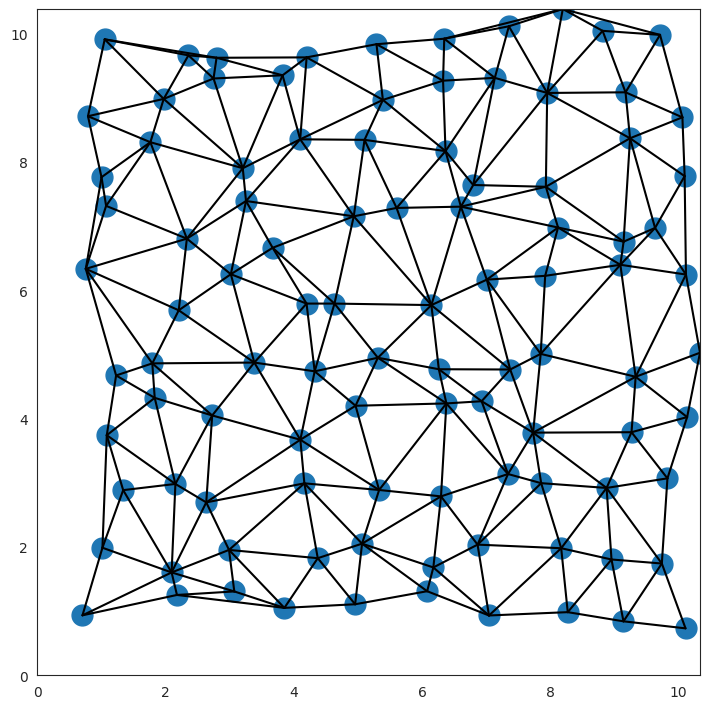

In [20]:
ms = 30
R_plt = onp.array(traj1['position'][-1])

plt.plot(R_plt[:N, 0], R_plt[:N, 1], 'o', markersize=ms * 0.5)

# Plotting bonds
for bond in E:
    point1 = R_plt[bond[0]]
    point2 = R_plt[bond[1]]
    plt.plot([point1[0], point2[0]], [point1[1], point2[1]], c='black')  # Using black for bond color


plt.xlim([0, np.max(R_plt[:, 0])])
plt.ylim([0, np.max(R_plt[:, 1])])

plt.axis('on')

finalize_plot((1, 1))

In [28]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation
from JSAnimation.IPython_display import display_animation
from IPython.display import HTML

# Set style
sns.set_style(style='white')

# Define the init function, which sets up the plot
def init():
    plt.xlim([0, np.max(traj2['position'][:, :, 0])])
    plt.ylim([0, np.max(traj2['position'][:, :, 1])])
    plt.axis('on')
    return plt

# Define the update function, which is called for each frame
def update(frame):
    plt.clf()  # Clear the current figure
    R_plt = traj2['position'][frame]
    plt.plot(R_plt[:N, 0], R_plt[:N, 1], 'o', markersize=ms * 0.5)

    # Annotating each atom with its index
    for i, coords in enumerate(R_plt[:N]):
        plt.annotate(str(i), (coords[0], coords[1]), 
                    xytext=(5,5), textcoords='offset points', 
                    fontsize=10, color='red')

    # Plotting bonds
    for bond in E:
        point1 = R_plt[bond[0]]
        point2 = R_plt[bond[1]]
        plt.plot([point1[0], point2[0]], [point1[1], point2[1]], c='black')  # Using black for bond color
    return plt

# Create the animation
ani = FuncAnimation(plt.figure(), update, frames=range(len(traj1['position'])), init_func=init, blit=False)

# Display the animation
HTML(ani.to_jshtml())

<IPython.core.display.Javascript object>

In [ ]:
R_new = displace_sources(R, source_idx, 0.5)

In [ ]:
bond_array = np.array(E)

In [ ]:
plot_configuration(R, bond_array, box_length)

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Convert the trajectory to a NumPy array
trajectory_array = np.array(traj_shifted)

# Create a subplot for the scatter plot
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter'}]], print_grid=False)

# Create a scatter plot using Plotly
trace = go.Scatter(x=trajectory_array[:, 0], y=trajectory_array[:, 1], mode='markers')
fig.add_trace(trace)

# Create and add slider
steps = []
for i, frame in enumerate(trajectory_array):
    step = dict(
        method="update",
        args=[
            {"x": [frame[:, 0]], "y": [frame[:, 1]]},
        ],
        label=str(i),
    )
    steps.append(step)

slider = dict(steps=steps, active=0, pad={"t": 50}, currentvalue={"prefix": "Frame: "})

fig.update_layout(sliders=[slider])

# Update the layout
fig.update_layout(
    width=600,
    height=600,
    xaxis=dict(title='X', showgrid=False),
    yaxis=dict(title='Y', showgrid=False),
    plot_bgcolor='rgba(255, 255, 255, 1)', # White background
    margin=dict(l=50, r=50, b=50, t=50) # Adjust margin if needed
)

fig.show()


In [ ]:
plt.plot(gradients)

In [ ]:
k_bond.shape

# Charges

In [ ]:
charges = random.uniform(random.PRNGKey(5), shape=(N, 1), minval=-1.5, maxval=1.5)

In [ ]:
#soft_sphere_fn = energy.soft_sphere_pair(displacement, sigma=1, epsilon=1, alpha=2) #sigma = particle diameter, epsilon = interaction energy scale, alpha = interaction stiffness
def custom_energy():
  lj_fn = energy.lennard_jones_pair(displacement, sigma=0.53, epsilon=1.0, r_onset=0.5, r_cutoff = 2.0)
  coulombic_fn = coulomb_direct_pair(displacement, charges, alpha=2.0)
  return lj_fn + coulombic_fn